In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
def printDS(x):
    print(list(x.as_numpy_iterator())[:5])

In [3]:
imgs_path = tf.data.Dataset.list_files('./Data/ACGPN_traindata/train_img/*.jpg', shuffle=False)
imgs_masks_path = tf.data.Dataset.list_files('./Data/ACGPN_traindata/train_mid_lab/*.png', shuffle=False)

imgs_path_ds = tf.data.Dataset.zip((imgs_path, imgs_masks_path))

In [4]:
list(imgs_path_ds.take(5).as_numpy_iterator())

[(b'./Data/ACGPN_traindata/train_img/000003_0.jpg',
  b'./Data/ACGPN_traindata/train_mid_lab/000003_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000004_0.jpg',
  b'./Data/ACGPN_traindata/train_mid_lab/000004_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000005_0.jpg',
  b'./Data/ACGPN_traindata/train_mid_lab/000005_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000006_0.jpg',
  b'./Data/ACGPN_traindata/train_mid_lab/000006_0.png'),
 (b'./Data/ACGPN_traindata/train_img/000007_0.jpg',
  b'./Data/ACGPN_traindata/train_mid_lab/000007_0.png')]

In [5]:
# imgs = [keras.preprocessing.image.load_img(x, target_size=(256, 256)) for x in imgs_path]
# imgs = tf.data.Dataset.from_tensor_slices(imgs)

# imgs_masks = [keras.preprocessing.image.load_img(x, target_size=(256, 256)) for x in imgs_masks_path]
# imgs_masks = tf.data.Dataset.from_tensor_slices(imgs_masks)

def process(x, y):
    img = tf.io.read_file(x)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (256, 256))
    img = img/255

    mask = tf.io.read_file(y)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = (mask != 30)
    return img, mask

img_ds = imgs_path_ds.map(lambda x, y: process(x, y))

In [6]:
# img_ds = img_ds.batch(64)

(256, 256, 3)
(256, 256, 1)


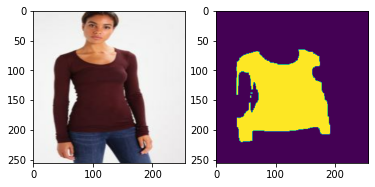

In [6]:
# a, b = list(img_ds.shuffle(100).take(1).as_numpy_iterator())[0]
a, b = list(img_ds.take(100).as_numpy_iterator())[23]

fig, ax = plt.subplots(ncols=2)
# i = np.random.randint(0, 64)
print(a.shape)
print(b.shape)
ax[0].imshow(a)
ax[1].imshow(b)

In [7]:
def downSample(inp, filters, kernel=(3, 3), strides=1, padding='same', activation='relu'):
    conv_1 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(inp)
    conv_2 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conv_1)
    maxpool = layers.MaxPool2D((2, 2))(conv_2)
    
    return conv_2, maxpool

def upSample(inp, cat, filters, kernel=(3, 3), strides=1, padding='same', activation='relu'):
    upSampled = layers.Conv2DTranspose(filters, kernel, (2, 2), padding, activation=activation)(inp)
    conct = layers.Concatenate()([upSampled, cat])
    conv_1 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conct)
    conv_2 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conv_1)
    
    return conv_2

def downSampleWOMaxPool(inp, filters, kernel=(3, 3), strides=1, padding='same', activation='relu'):
    conv_1 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(inp)
    conv_2 = layers.Conv2D(filters, kernel, strides, padding, activation=activation)(conv_1)
    
    return conv_2

In [8]:
def getUNet():
    
    filters = [
        64,
        128,
        256,
        512,
        1024
    ]
    
    # 256x256
    inp = layers.Input((256, 256, 3))
    
    # 256x256 -> 128x128
    c1, mp1 = downSample(inp, filters[0])
    
    # 128x128 -> 64x64
    c2, mp2 = downSample(mp1, filters[1])
    
    # 64x64 -> 32x32
    c3, mp3 = downSample(mp2, filters[2])
    
    # 32x32 -> 16x16
    c4, mp4 = downSample(mp3, filters[3])
    
    # 16 mid layer
    c5 = downSampleWOMaxPool(mp4, filters[4])
    
    # 16x16 -> 32x32
    us1 = upSample(c5, c4, filters[3])
    
    # 32x32 -> 64x64
    us2 = upSample(us1, c3, filters[2])
    
    # 64x64 -> 128x128
    us3 = upSample(us2, c2, filters[1])
    
    # 128x128 -> 256x256
    us4 = upSample(us3, c1, filters[0])
    
    out = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(us4)
    
    return models.Model(inp, out)

In [9]:
model = getUNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
# model.summary()

In [10]:
model.load_weights('./Unet-Try-Viton-mid-model-save(0.9928-acc)/model_weights.h5')

In [11]:
# img_ds = img_ds.unbatch()
sharded_img_ds = img_ds.shard(3, 0)
sharded_img_ds_batched = sharded_img_ds.batch(32)

sharded_img_ds1 = img_ds.shard(600, 1)
sharded_img_ds1_batched = sharded_img_ds1.batch(32)

In [14]:
# history = model.fit(sharded_img_ds_batched, epochs=50)

NameError: name 'model' is not defined

In [12]:
def get_test_imgs():
    test_img = tf.data.Dataset.list_files('./testImgs/*.jpg', shuffle=False)
    test_img1 = tf.data.Dataset.list_files('./testImgs/*.jpg', shuffle=False)
    test_img_ds = tf.data.Dataset.zip((test_img, test_img1))
    
    def processTest(x, y):
        img = tf.io.read_file(x)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, (256, 256))
        img = img/255

        mask = tf.io.read_file(y)
        mask = tf.image.decode_jpeg(mask, channels=1)
        mask = tf.image.resize(mask, (256, 256))
        mask = mask/255
        return img, mask

    return test_img_ds.map(lambda x, y: processTest(x, y))

test_img_ds = get_test_imgs()

2


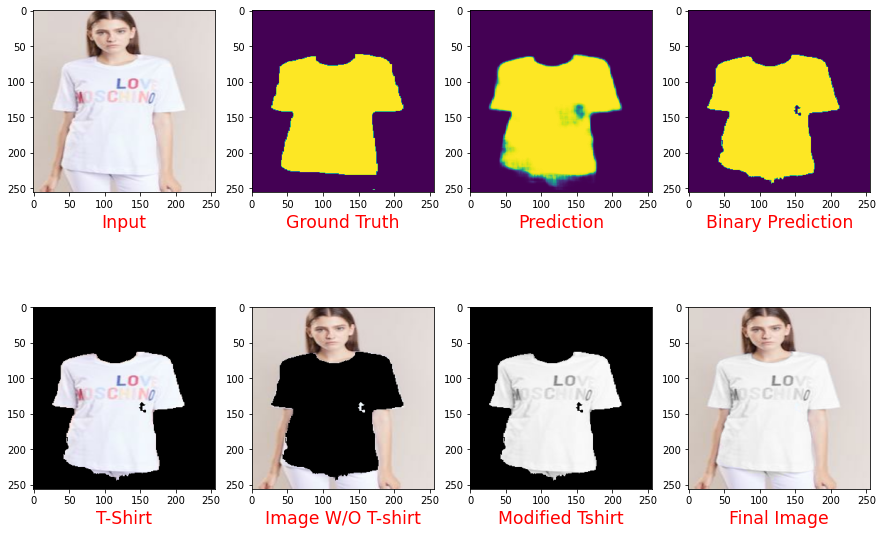

In [13]:
rg = 200
rd = np.random.randint(0, rg)
print(rd%3)

a, b = list(img_ds.take(rg).as_numpy_iterator())[rd]

# a, b = list(test_img_ds.take(1).as_numpy_iterator())[0]

x = np.array(a)
x = np.expand_dims(x, axis=0)
# print(x.shape)
ot = model.predict(x)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
ax[0, 0].imshow(a)
ax[0, 0].set_xlabel("Input", fontsize='xx-large', color='red')

ax[0, 1].imshow(b)
ax[0, 1].set_xlabel("Ground Truth", fontsize='xx-large', color='red')

ax[0, 2].imshow(ot[0])
ax[0, 2].set_xlabel("Prediction", fontsize='xx-large', color='red')

ax[0, 3].imshow(ot[0] > 0.5)
ax[0, 3].set_xlabel("Binary Prediction", fontsize='xx-large', color='red')

mask = ot[0] > 0.5

ax[1, 0].imshow(mask*a)
ax[1, 0].set_xlabel("T-Shirt", fontsize='xx-large', color='red')

ax[1, 1].imshow(a*(1-mask))
ax[1, 1].set_xlabel("Image W/O T-shirt", fontsize='xx-large', color='red')

ig = (mask*a).mean(axis=2).reshape((256, 256, 1))

k = ig
ig = np.append(ig, k, axis=2)
ig = np.append(ig, k, axis=2)
ig = ig/ig.max()

ax[1, 2].imshow(ig)
ax[1, 2].set_xlabel("Modified Tshirt", fontsize='xx-large', color='red')

ig_final = ig+(a*(1-mask))
# ax[0, 1].imshow(ig_final)
ax[1, 3].imshow(ig_final)
ax[1, 3].set_xlabel("Final Image", fontsize='xx-large', color='red');

In [30]:
iou_master = 0
test_size = 1000

rg = 10000
dsn = list(img_ds.take(rg).as_numpy_iterator())

for k in range(test_size):
    rd = np.random.randint(0, rg)
    while(rd%3 == 0):
        rd = np.random.randint(0, rg)

    a, b = dsn[rd]

    # a, b = list(test_img_ds.take(1).as_numpy_iterator())[0]

    x = np.array(a)
    x = np.expand_dims(x, axis=0)
    # print(x.shape)
    ot = model.predict(x)

    ground_truth = b
    prediction = ot[0] > 0.5

#     fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 10))
#     ax[0].imshow(a)
#     ax[0].set_xlabel("Input", fontsize='xx-large', color='red')

#     ax[1].imshow(b)
#     ax[1].set_xlabel("Ground Truth", fontsize='xx-large', color='red')

#     ax[2].imshow(ground_truth)
#     ax[2].set_xlabel("Binary Prediction", fontsize='xx-large', color='red')

#     ax[3].imshow(ground_truth*b)
#     ax[3].set_xlabel("Intersection", fontsize='xx-large', color='red')

#     ax[4].imshow((ground_truth+b)/2)
#     ax[4].set_xlabel("Union", fontsize='xx-large', color='red')

    iou = 0

    un = 0
    ints = 0

    for x in range(256):
        for y in range(256):
            if(ground_truth[x, y] and prediction[x, y]):
                ints += 1

            if(ground_truth[x, y] or prediction[x, y]):
                un += 1

    iou = ints/un
    iou_master += iou

    print(k/test_size, "->", iou, end="\r")

iou_master /= test_size
print("IOU: ", iou_master)


IOU:  0.92848281766986823016


In [31]:
iou_master

0.9284828176698682

In [17]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

# model.save_weights("model_weights.h5")
# print("Saved model to disk")

NameError: name 'model' is not defined

## https://github.com/NiveditJain/Simultaneous-Optimisation-of-Image-Quality-Improvement-and-Text-Content-Extraction-from-scanned-docu/blob/master/Models/SRCNN%20modified%20loss%20with%20regularisation/train.py